In [79]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from pathlib import Path
from data_treatment.box_creator import create_binary_box
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

os.chdir(root)

## Preparing Data

In [80]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]

,PX_OPEN_VIX_volatility,Box
Date,,
2006-02-28,11.74,0
2006-03-01,12.05,1
2006-03-02,11.79,1
2006-03-03,12.03,1
2006-03-06,12.22,1
...,...,...
2021-05-18,18.89,1
2021-05-19,22.46,0
2021-05-20,22.33,0


In [81]:
def add_AR_cols(df: pd.DataFrame, lags: int, return_cols=False)-> pd.DataFrame:
    """
    added columns defined by VIX_lagged_i = VIX - VIX_-i
    :param df: DataFrame containing all variables
    :param lags: number of passed unit time added to the DataFrame
    :return: the DataFrame with the lagged columns
    """
    VIX = 'PX_OPEN_VIX_volatility'
    cols=[]

    for i in range(1,lags):
        df['VIX_LAG_' + str(i)] = df[VIX] - df[VIX].shift(i)
        cols.append('VIX_LAG_' + str(i))


    if return_cols: return df.dropna(), cols
    else: return df.dropna()

In [82]:
df, cols = add_AR_cols(df,7, return_cols=True)
cols += ["PX_OPEN_VIX_volatility",'S&P 500 Weekly Close_SENTIMENT' ]

In [83]:
df

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LOW_VIX_volatility,PX_LAST_VIX_volatility,VOLUME_TOTAL_CALL_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,VOLUME_TOTAL_PUT_VIX_volatility,TOT_OPT_VOLUME_CUR_DAY_VIX_volatility,OPEN_INT_TOTAL_CALL_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,...,CMA_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily,Mom _F-F_Momentum_Factor_daily,Box,VIX_LAG_1,VIX_LAG_2,VIX_LAG_3,VIX_LAG_4,VIX_LAG_5,VIX_LAG_6
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-08,12.83,13.34,12.26,12.32,505.0,0.7525,380.0,885.0,45781.0,35778.0,...,-0.04,0.016,-0.20,0,-0.09,0.61,0.80,1.04,0.78,1.09
2006-03-09,12.21,12.69,12.01,12.68,2335.0,0.3148,735.0,3070.0,44848.0,36098.0,...,0.13,0.016,-0.24,0,-0.62,-0.71,-0.01,0.18,0.42,0.16
2006-03-10,12.52,12.60,11.79,11.85,722.0,0.8089,584.0,1306.0,46964.0,36383.0,...,0.09,0.016,-0.10,0,0.31,-0.31,-0.40,0.30,0.49,0.73
2006-03-13,11.72,11.75,11.13,11.37,1183.0,1.1851,1402.0,2585.0,47803.0,36937.0,...,-0.11,0.016,0.34,0,-0.80,-0.49,-1.11,-1.20,-0.50,-0.31
2006-03-14,11.61,11.72,10.53,10.74,5130.0,0.1043,535.0,5665.0,48279.0,38306.0,...,-0.22,0.016,0.70,0,-0.11,-0.91,-0.60,-1.22,-1.31,-0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,18.89,21.45,18.81,21.34,435445.0,0.8205,357293.0,792738.0,6190495.0,4299845.0,...,-0.42,0.000,-0.26,1,-1.00,-2.88,-7.14,-3.53,-2.28,1.55
2021-05-19,22.46,25.96,21.88,22.18,417537.0,1.2020,501893.0,919430.0,4725251.0,3133065.0,...,-0.34,0.000,-0.70,0,3.57,2.57,0.69,-3.57,0.04,1.29
2021-05-20,22.33,23.50,20.19,20.67,208977.0,0.8944,186913.0,395890.0,4842985.0,3207980.0,...,-0.49,0.000,0.20,0,-0.13,3.44,2.44,0.56,-3.70,-0.09


In [84]:
y = df['Box']
X = df.drop(['Box'], axis=1)

X_sm = sm.add_constant(X[cols])

## Training models

### Statsmodel to search for pertinent exogenes variables

In [85]:
log_reg = sm.Logit(y,X_sm)
print(log_reg.fit().summary())

Optimization terminated successfully.
         Current function value: 0.683964
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    Box   No. Observations:                 2413
Model:                          Logit   Df Residuals:                     2404
Method:                           MLE   Df Model:                            8
Date:                Tue, 04 Jan 2022   Pseudo R-squ.:                 0.01030
Time:                        21:49:46   Log-Likelihood:                -1650.4
converged:                       True   LL-Null:                       -1667.6
Covariance Type:            nonrobust   LLR p-value:                 3.500e-05
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0694      0.161      0.430     

### scikit-learn to use penalization

In [86]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

selec_model = SelectKBest(k=25)
selec_model.fit(X_train, y_train)
selec_model.get_feature_names_out()

X_new = selec_model.transform(X_train)

In [87]:
from sklearn.linear_model import LogisticRegression

pipe_LogReg = make_pipeline(SelectKBest(k=25),StandardScaler(),LogisticRegression(fit_intercept=True))

pipe_LogReg.fit(X_train,y_train)

pipe_LogReg.named_steps['selectkbest'].get_feature_names_out()

array(['PX_OPEN_VIX_volatility', 'PX_LOW_VIX_volatility',
       'VOLUME_TOTAL_CALL_VIX_volatility',
       'PUT_CALL_VOLUME_RATIO_CUR_DAY_SPX_volatility',
       'VOLUME_TOTAL_PUT_SPX_volatility', 'VOLATILITY_30D_SPX_volatility',
       'VOLATILITY_10D_SPX_volatility', 'VOLATILITY_20D_SPX_volatility',
       'VOLATILITY_30D_SX5E_volatility', 'VOLATILITY_90D_SX5E_volatility',
       'VOLATILITY_60D_SX5E_volatility', 'VOLATILITY_20D_SX5E_volatility',
       'PX_OPEN_VSTOXX_volatility', 'PX_HIGH_VSTOXX_volatility',
       'PX_LOW_VSTOXX_volatility', 'QMJ USA_QMJ Factors',
       'QMJ Global_QMJ Factors', 'ST_Rev_F-F_ST_Reversal_Factor_daily',
       'Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily',
       'SMB_F-F_Research_Data_5_Factors_2x3_daily',
       'CMA_F-F_Research_Data_5_Factors_2x3_daily', 'VIX_LAG_1',
       'VIX_LAG_3', 'VIX_LAG_4', 'VIX_LAG_5'], dtype=object)

In [88]:
score = pipe_LogReg.score(X_train, y_train)
print("Score: ", score)

Score:  0.6632124352331606


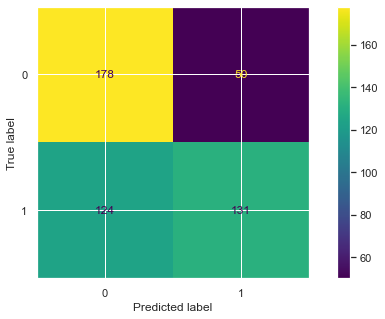

In [89]:
ConfusionMatrixDisplay.from_estimator(estimator=pipe_LogReg, X=X_test, y=y_test)

/var/folders/tw/0_4t24xd3vs3yb_2z5jssqnc0000gn/T/ipykernel_46166/645878326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pred']= pipe_LogReg.predict(df1.drop(['Box'], axis=1))


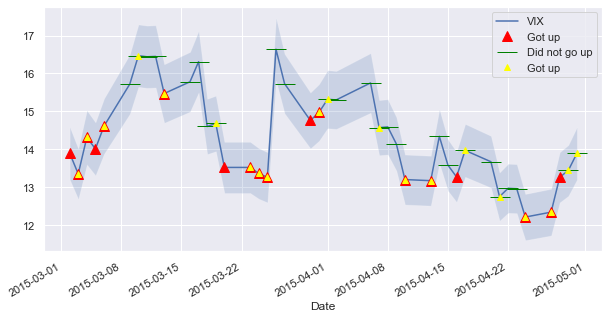

In [96]:
df1 = df['2015-03':'2015-04']

df1['pred']= pipe_LogReg.predict(df1.drop(['Box'], axis=1))

fig, ax = plt.subplots()
base = df1['PX_OPEN_VIX_volatility'].plot(ax=ax, label='VIX')


got_out = df1.loc[df1['Box']==1]
no_got_out = df1.loc[df1['Box']==0]

pred_got_out = df1.loc[df1['pred']==1]


ax.plot(got_out.index.values, got_out['PX_OPEN_VIX_volatility'], '^', markersize=10, color='red', lw=2, label='Got up')

ax.plot(no_got_out.index, no_got_out['PX_OPEN_VIX_volatility'], '_', markersize = 20, color='green', lw=2, label='Did not go up');

ax.plot(pred_got_out.index.values, pred_got_out['PX_OPEN_VIX_volatility'], '^', markersize=6, color='yellow', lw=2, label='Got up')

ax.fill_between(df1.index, df1['PX_OPEN_VIX_volatility']*(1.05), df1['PX_OPEN_VIX_volatility']*(0.95), alpha=0.2)
plt.legend(loc='best')
plt.show()